In [7]:
# Import necessary modules and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPool2D, BatchNormalization, GlobalMaxPool2D, Activation, Flatten, Conv2DTranspose
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

#Declare some constants
epoch = 1000
batch_size = 16
kernel = (3, 3)
reg_constant = 0.025
learning_rate = 0.003
decay_rate = 0.001
print("Learning rate = {} -- Decay rate = {}".format(learning_rate, decay_rate))

Learning rate = 0.003 -- Decay rate = 0.001


In [2]:
print("Load Train Data")
data = pd.read_json("data/train.json")
target_train = data['is_iceberg']
x1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
x2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])
x3 = (x1 + x2) / 2
data_train = np.stack([x1, x2, x3], axis=-1)
print('data_train.shape: ', data_train.shape)
inp_shape = (75, 75, data_train.shape[3])

Load Train Data
data_train.shape:  (1604, 75, 75, 3)


In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train, to_categorical(target_train, 2), test_size=0.25)

img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=45, zoom_range=0.2)

img_gen.fit(X_train, augment=True, rounds=3)

gen_train = img_gen.flow(X_train, y_train, batch_size)
gen_valid = img_gen.flow(X_valid, y_valid, batch_size)

steps_train = len(X_train) / batch_size
steps_valid = len(X_valid) / batch_size


In [13]:
def classifier():
    clf = Sequential()
    clf.add(BatchNormalization(input_shape=inp_shape))
    
    clf.add(Conv2D(32, kernel, activation='relu', kernel_regularizer=l2(reg_constant), padding='same', bias_initializer='glorot_uniform'))
    clf.add(Conv2D(32, kernel, activation='relu', padding='same', bias_initializer='glorot_uniform'))
    clf.add(MaxPool2D())
    
    clf.add(Conv2D(64, kernel, activation='relu', kernel_regularizer=l2(reg_constant), padding='same', bias_initializer='glorot_uniform'))
    clf.add(Conv2D(64, kernel, activation='relu', padding='same', bias_initializer='glorot_uniform'))
    clf.add(MaxPool2D())
    
    clf.add(Conv2D(256, kernel, activation='relu', kernel_regularizer=l2(reg_constant), bias_initializer='glorot_uniform', padding='same'))
    clf.add(Conv2D(256, kernel, activation='relu', bias_initializer='glorot_uniform', padding='same'))

    clf.add(GlobalMaxPool2D())
    clf.add(Dense(units=32, activation='relu', bias_initializer='glorot_uniform'))
    clf.add(Dense(units=16, activation='relu', bias_initializer='glorot_uniform'))
    clf.add(Dense(units=2, activation='softmax', bias_initializer='glorot_uniform'))
    clf.summary()
    ada = Adam(lr=learning_rate, decay=decay_rate)

    clf.compile(optimizer=ada, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return clf

model = classifier()
stop = EarlyStopping(monitor='val_loss', patience=8)
lr = ReduceLROnPlateau(factor=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [14]:
t0 = time()
his = model.fit_generator(generator=gen_train, steps_per_epoch=steps_train, epochs=epoch, callbacks=[lr, stop],
                          validation_data=gen_valid, validation_steps=steps_valid)

print('Time taken = %.2f sec' % (time() - t0))

Epoch 1/1000
76/75 [==============================] - 132s - loss: 1.6846 - categorical_accuracy: 0.5260 - val_loss: 0.9147 - val_categorical_accuracy: 0.4838
Epoch 2/1000
76/75 [==============================] - 131s - loss: 0.7964 - categorical_accuracy: 0.5268 - val_loss: 0.7568 - val_categorical_accuracy: 0.4688
Epoch 3/1000
76/75 [==============================] - 130s - loss: 0.7442 - categorical_accuracy: 0.5184 - val_loss: 0.7228 - val_categorical_accuracy: 0.5262
Epoch 4/1000
76/75 [==============================] - 127s - loss: 0.7311 - categorical_accuracy: 0.5291 - val_loss: 0.7005 - val_categorical_accuracy: 0.5237
Epoch 5/1000
76/75 [==============================] - 131s - loss: 0.7015 - categorical_accuracy: 0.5425 - val_loss: 0.7276 - val_categorical_accuracy: 0.5337
Epoch 6/1000
76/75 [==============================] - 132s - loss: 0.7341 - categorical_accuracy: 0.4984 - val_loss: 0.7073 - val_categorical_accuracy: 0.5287
Epoch 7/1000
76/75 [==========================

76/75 [==============================] - 170s - loss: 0.3630 - categorical_accuracy: 0.8503 - val_loss: 0.3285 - val_categorical_accuracy: 0.8728
Epoch 53/1000
76/75 [==============================] - 155s - loss: 0.3582 - categorical_accuracy: 0.8470 - val_loss: 0.3497 - val_categorical_accuracy: 0.8828
Epoch 54/1000
76/75 [==============================] - 173s - loss: 0.3620 - categorical_accuracy: 0.8429 - val_loss: 0.3522 - val_categorical_accuracy: 0.8554
Epoch 55/1000
76/75 [==============================] - 160s - loss: 0.4459 - categorical_accuracy: 0.8104 - val_loss: 0.3378 - val_categorical_accuracy: 0.8653
Epoch 56/1000
76/75 [==============================] - 157s - loss: 0.3525 - categorical_accuracy: 0.8503 - val_loss: 0.4027 - val_categorical_accuracy: 0.8404
Epoch 57/1000
76/75 [==============================] - 170s - loss: 0.3585 - categorical_accuracy: 0.8443 - val_loss: 0.3503 - val_categorical_accuracy: 0.8678
Epoch 58/1000
76/75 [==============================] -

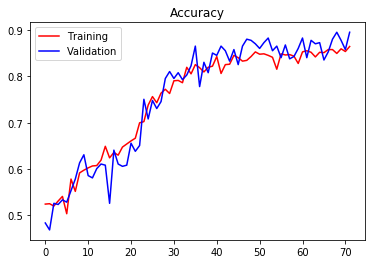

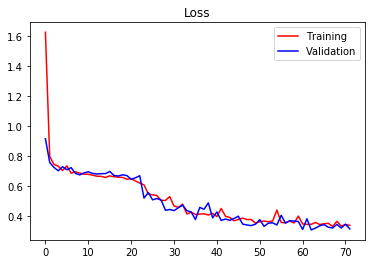

In [15]:
# Plots
x_ = np.arange(len(his.epoch))
plt.figure(1)
plt.title('Accuracy')
plt.plot(x_, his.history['categorical_accuracy'], 'r', label='Training')
plt.plot(x_, his.history['val_categorical_accuracy'], 'b', label='Validation')
plt.legend()
plt.show()

plt.figure(2)
plt.title('Loss')
plt.plot(x_, his.history['loss'], 'r', label='Training')
plt.plot(x_, his.history['val_loss'], 'b', label='Validation')
plt.legend()
plt.show()
